In [1]:
import sas7bdat_converter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index

### Bring in Data

In [2]:
file_dicts = [
  {
    'sas7bdat_file': '/Users/rheajaisinghani/Downloads/dnmepi.sas7bdat',
    'export_file': '/Users/rheajaisinghani/Desktop/OTC/NHANES Data/dnmepi.csv',
  },
]
sas7bdat_converter.batch_to_csv(file_dicts)

In [56]:
dna = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/dnmepi.csv")

In [57]:
dem1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/DEMO_99.csv")
dem2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/DEMO_01.csv")

In [58]:
combined_dem = pd.concat([dem1, dem2], axis=0, ignore_index=True)
age = combined_dem[['SEQN', 'RIDAGEYR']]

In [59]:
cig1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/SMQ_99.csv")
cig2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/SMQ_01.csv")

combined_cig = pd.concat([cig1, cig2], axis=0, ignore_index=True)
cig = combined_cig[['SEQN', 'SMQ040']]

def determine_smoker(smq040):
    if pd.isnull(smq040):
        return 'Unknown'
    elif smq040 in [1, 2]:
        return True
    elif smq040 == 3:
        return False
    else:
        return 'Unknown'

cig['smoker'] = cig['SMQ040'].apply(determine_smoker)

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_13512/1523983905.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cig['smoker'] = cig['SMQ040'].apply(determine_smoker)


In [60]:
bmi1 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/BMX_99.csv")
bmi2 = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/NHANES Data/BMX_01.csv")

combined_bmi = pd.concat([bmi1, bmi2], axis=0, ignore_index=True)
bmi = combined_bmi[['SEQN', 'BMXBMI']]
bmi = bmi.loc[bmi['BMXBMI'].notnull()]
bmi['BMI_risk'] = bmi['BMXBMI'] > 25
bmi['BMI_risk'] = bmi['BMI_risk'].fillna('Unknown')

In [61]:
dna = dna.merge(age.rename(columns={'RIDAGEYR': 'true_age'}), on='SEQN', how='left')

In [62]:
dna = dna.merge(cig[['SEQN', 'smoker']], on='SEQN', how='left')

In [63]:
dna = dna.merge(bmi[['SEQN', 'BMI_risk']], on='SEQN', how='left')

In [64]:
dna['BMI_risk'] = dna['BMI_risk'].fillna('Unknown')

In [65]:
dna.columns

Index(['SEQN', 'XY_Estimation', 'HorvathAge', 'HannumAge', 'SkinBloodAge',
       'PhenoAge', 'GDF15Mort', 'B2MMort', 'CystatinCMort', 'TIMP1Mort',
       'ADMMort', 'PAI1Mort', 'LeptinMort', 'PACKYRSMort', 'CRPMort',
       'logA1CMort', 'GrimAgeMort', 'GrimAge2Mort', 'HorvathTelo', 'YangCell',
       'ZhangAge', 'LinAge', 'WeidnerAge', 'VidalBraloAge', 'DunedinPoAm',
       'CD8TPP', 'CD4TPP', 'Nkcell', 'Bcell', 'MonoPP', 'NeuPP', 'WTDN4YR',
       'true_age', 'smoker', 'BMI_risk'],
      dtype='object')

### EDA: Age Bucket Trends

In [15]:
bins = [50, 55, 60, 65, 70, 75, 80, 86]
labels = ['50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-85']

In [66]:
dna['age_bucket'] = pd.cut(dna['true_age'], bins=bins, labels=labels)
age_buckets = dna.groupby('age_bucket').agg({
    'HorvathAge': ['mean', 'std'],
    'HannumAge': ['mean', 'std'],
    'SkinBloodAge': ['mean', 'std'],
    'PhenoAge': ['mean', 'std']
}).reset_index()

age_buckets.columns = ['age_bucket', 
                       'mean_horvath_age', 'std_horvath_age', 
                       'mean_hannum_age', 'std_hannum_age', 
                       'mean_skinblood_age', 'std_skinblood_age', 
                       'mean_pheno_age', 'std_pheno_age']

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_13512/3452229376.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_buckets = dna.groupby('age_bucket').agg({


In [17]:
plot_data_epi = dna[['HorvathAge', 'HannumAge', 'PhenoAge', 'SkinBloodAge', 'age_bucket', 'true_age']]

In [67]:
dna['horvath_residual'] = dna['HorvathAge'] - dna['true_age']
dna['hannum_residual'] = dna['HannumAge'] - dna['true_age']
dna['skinblood_residual'] = dna['SkinBloodAge'] - dna['true_age']
dna['pheno_residual'] = dna['PhenoAge'] - dna['true_age']

residual_buckets = dna.groupby('age_bucket').agg({
    'horvath_residual': ['mean', 'std'],
    'hannum_residual': ['mean', 'std'],
    'skinblood_residual': ['mean', 'std'],
    'pheno_residual': ['mean', 'std']
}).reset_index()

residual_buckets.columns = ['age_bucket', 
                       'mean_horvath_age_res', 'std_horvath_age_res', 
                       'mean_hannum_age_res', 'std_hannum_age_res', 
                       'mean_skinblood_age_res', 'std_skinblood_age_res', 
                       'mean_pheno_age_res', 'std_pheno_age_res']

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_13512/179904161.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  residual_buckets = dna.groupby('age_bucket').agg({


### New Model Comparison (Trained on 50+ All Participants)

In [21]:
model_results = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/gpt1536_raw_50plus_analysis.csv")

In [54]:
cig_risk = pd.read_csv('/Users/rheajaisinghani/Desktop/OTC/cig_risk.csv')
model_results['smoker'] = model_results['SEQN'].isin(cig_risk['SEQN'])

In [68]:
model_results['age_bucket'] = pd.cut(model_results['y_true'], bins=bins, labels=labels)

In [69]:
age_comparison = model_results.groupby('age_bucket')['residual'].mean().reset_index(name='model_residual')
age_comparison = age_comparison.merge(
    dna.groupby('age_bucket')['horvath_residual'].mean().reset_index(name='horvath_residual'),
    on='age_bucket',
    how='inner'
)
print("Comparison by Age Group:")
print(age_comparison)

Comparison by Age Group:
  age_bucket  model_residual  horvath_residual
0      50-54        7.652019          4.311784
1      55-59        4.107028          2.691357
2      60-64        1.864569          1.651043
3      65-69       -1.623649          0.385125
4      70-74       -4.789265         -1.104799
5      75-79       -7.504766         -2.788455
6      80-85      -10.976154         -3.473510


/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_13512/3788449045.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_comparison = model_results.groupby('age_bucket')['residual'].mean().reset_index(name='model_residual')
/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_13512/3788449045.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dna.groupby('age_bucket')['horvath_residual'].mean().reset_index(name='horvath_residual'),


In [71]:
dna

,SEQN,XY_Estimation,HorvathAge,HannumAge,SkinBloodAge,PhenoAge,GDF15Mort,B2MMort,CystatinCMort,TIMP1Mort,...,NeuPP,WTDN4YR,true_age,smoker,BMI_risk,age_bucket,horvath_residual,hannum_residual,skinblood_residual,pheno_residual
0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,77.0,Unknown,False,75-79,NaN,NaN,NaN,NaN
1,7.0,1.0,62.484906,43.790026,50.977392,31.965868,810.940037,1545146.137,570694.3868,32937.37877,...,0.425682,20752.885955,59.0,False,True,55-59,3.484906,-15.209974,-8.022608,-27.034132
2,13.0,2.0,76.119340,78.857218,69.883279,73.680914,1127.296957,1768383.141,694439.3696,37740.30988,...,0.850470,1260.059101,70.0,False,True,65-69,6.119340,8.857218,-0.116721,3.680914
3,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,81.0,True,True,80-85,NaN,NaN,NaN,NaN
4,16.0,1.0,80.204158,77.042360,81.737482,67.810727,1190.042227,1951256.905,633099.8724,34858.26081,...,0.636939,13383.476924,85.0,Unknown,False,80-85,-4.795842,-7.957640,-3.262518,-17.189273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4444,20992.0,1.0,59.904151,57.717009,56.938698,47.728722,729.295842,1547502.657,645082.1697,34394.91986,...,0.499003,2442.972223,61.0,Unknown,True,60-64,-1.095849,-3.282991,-4.061302,-13.271278
4445,20994.0,1.0,61.475433,60.242856,60.666521,46.223037,921.129679,1653577.290,610190.4250,34735.50662,...,0.418354,9860.720203,67.0,True,True,65-69,-5.524567,-6.757144,-6.333479,-20.776963
4446,20995.0,1.0,74.456195,75.875069,77.444468,73.808099,1002.341330,1892589.308,662739.6906,37326.33747,...,0.586724,26682.173948,81.0,False,False,80-85,-6.543805,-5.124931,-3.555532,-7.191901
4447,20996.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,77.0,False,Unknown,75-79,NaN,NaN,NaN,NaN


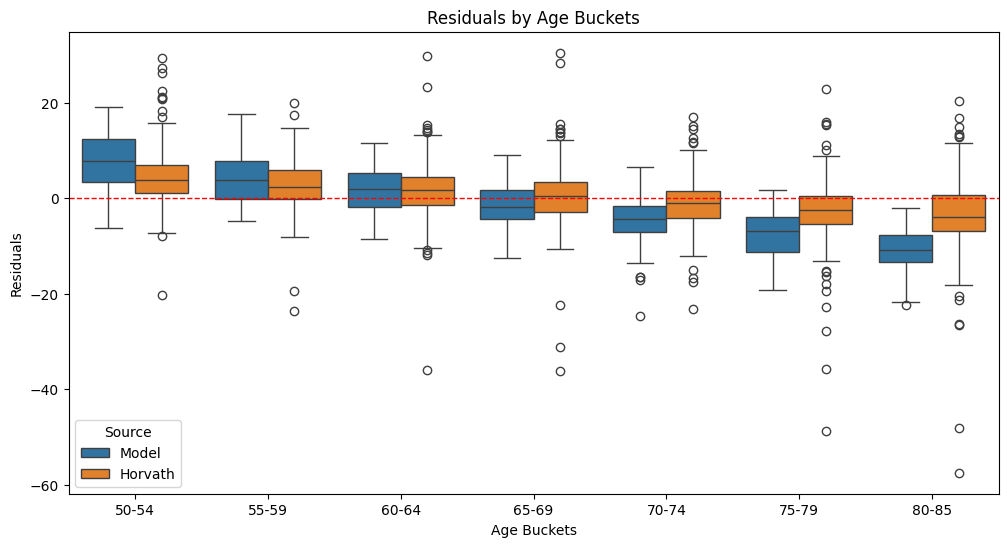

In [72]:
temp_model = model_results.copy()
temp_model['source'] = 'Model'

temp_dna = dna.copy()
temp_dna['source'] = 'Horvath'

temp_model = temp_model[['y_true', 'residual', 'source', 'BMI_Risk', 'smoker']]
temp_dna = temp_dna[['true_age', 'horvath_residual', 'source', 'BMI_risk', 'smoker']]

columns  = ['true_age', 'residual', 'source', 'BMI_risk', 'smoker']
temp_model.columns = columns
temp_dna.columns = columns

data = pd.concat([temp_model, temp_dna], ignore_index=True)
data['age_bucket'] = pd.cut(data['true_age'], bins=bins, labels=labels)

plt.figure(figsize=(12, 6))
sns.boxplot(x='age_bucket', y='residual', hue='source', data=data)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at y=0
plt.title('Residuals by Age Buckets')
plt.xlabel('Age Buckets')
plt.ylabel('Residuals')
plt.legend(title='Source')
plt.show()

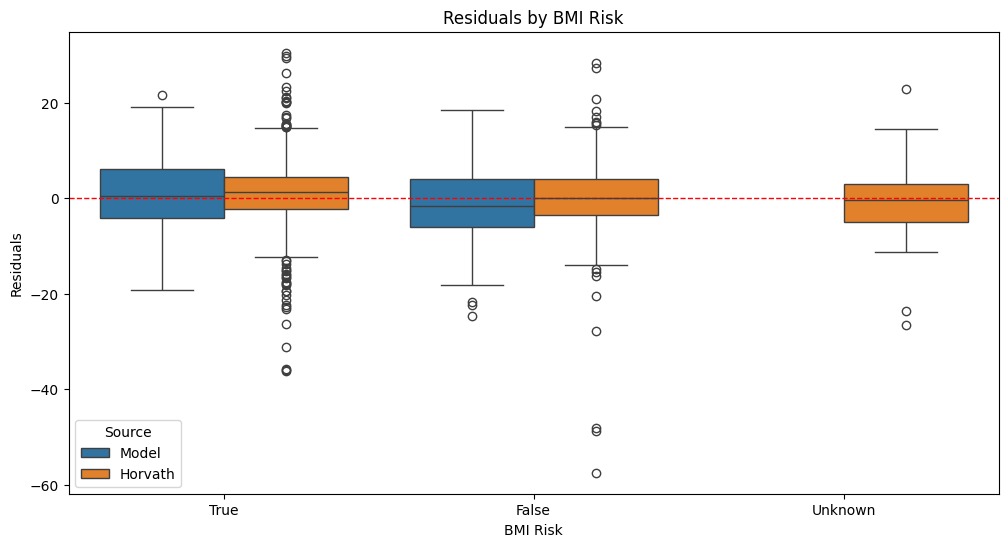

In [73]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='BMI_risk', y='residual', hue='source', data=data)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at y=0
plt.title('Residuals by BMI Risk')
plt.xlabel('BMI Risk')
plt.ylabel('Residuals')
plt.legend(title='Source')
plt.show()

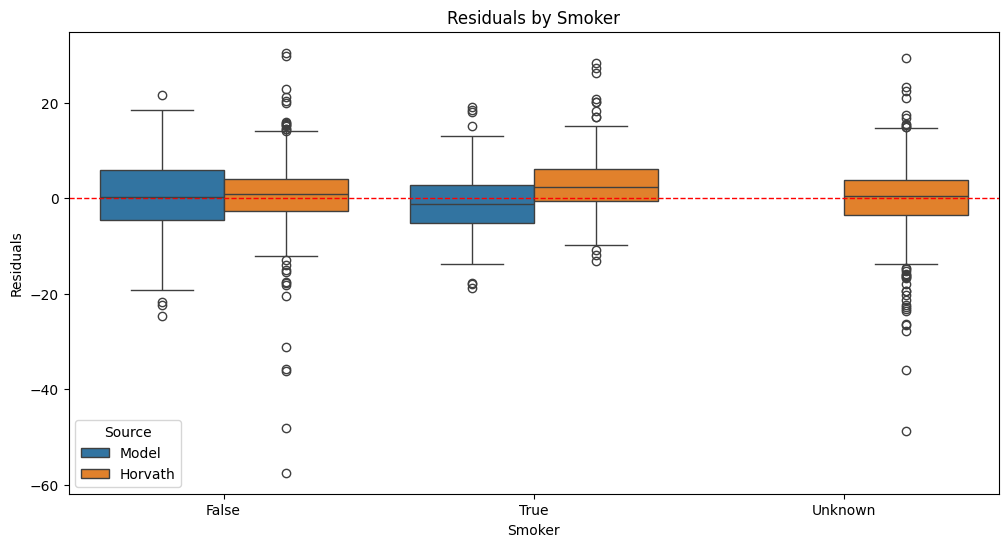

In [74]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='smoker', y='residual', hue='source', data=data)
plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Add horizontal line at y=0
plt.title('Residuals by Smoker')
plt.xlabel('Smoker')
plt.ylabel('Residuals')
plt.legend(title='Source')
plt.show()

### Old Model Comparison (Trained on 50+ Healthy Participants)

In [70]:
healthy_pred = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/healthy_gpt1536_raw_50.csv")
unhealthy_pred = pd.read_csv("/Users/rheajaisinghani/Desktop/OTC/unhealthy_gpt1536_raw_50.csv")

In [46]:
healthy_pred['age_bucket'] = pd.cut(healthy_pred['Actual Age'], bins=bins, labels=labels)
unhealthy_pred['age_bucket'] = pd.cut(unhealthy_pred['actual'], bins=bins, labels=labels)

In [17]:
healthy_age_buckets = healthy_pred.groupby('age_bucket')['Predicted Age'].agg(['mean', 'std']).reset_index()
healthy_age_buckets.rename(columns={'mean': 'mean_healthy_pred_age', 'std': 'std_healthy_pred_age'}, inplace=True)

unhealthy_age_buckets = unhealthy_pred.groupby('age_bucket')['predicted'].agg(['mean', 'std']).reset_index()
unhealthy_age_buckets.rename(columns={'mean': 'mean_unhealthy_pred_age', 'std': 'std_unhealthy_pred_age'}, inplace=True)

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/3609424857.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  healthy_age_buckets = healthy_pred.groupby('age_bucket')['Predicted Age'].agg(['mean', 'std']).reset_index()
/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/3609424857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unhealthy_age_buckets = unhealthy_pred.groupby('age_bucket')['predicted'].agg(['mean', 'std']).reset_index()


In [18]:
merged_buckets = age_buckets.merge(healthy_age_buckets, on='age_bucket', how='outer')
merged_buckets = merged_buckets.merge(unhealthy_age_buckets, on='age_bucket', how='outer')

In [81]:
healthy_pred['residual'] = healthy_pred['Predicted Age'] - healthy_pred['Actual Age']
unhealthy_pred['residual'] = unhealthy_pred['predicted'] - unhealthy_pred['actual']

healthy_pred = healthy_pred.rename(columns={'Predicted Age': 'HealthPredAge'})
unhealthy_pred = unhealthy_pred.rename(columns={'predicted': 'UnhealthPredAge'})

In [21]:
healthy_residual_buckets = healthy_pred.groupby('age_bucket')['residual'].agg(['mean', 'std']).reset_index()
healthy_residual_buckets.rename(columns={'mean': 'mean_healthy_residual', 'std': 'std_healthy_residual'}, inplace=True)

unhealthy_residual_buckets = unhealthy_pred.groupby('age_bucket')['residual'].agg(['mean', 'std']).reset_index()
unhealthy_residual_buckets.rename(columns={'mean': 'mean_unhealthy_residual', 'std': 'std_unhealthy_residual'}, inplace=True)

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/1658064757.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  healthy_residual_buckets = healthy_pred.groupby('age_bucket')['residual'].agg(['mean', 'std']).reset_index()
/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/1658064757.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unhealthy_residual_buckets = unhealthy_pred.groupby('age_bucket')['residual'].agg(['mean', 'std']).reset_index()


In [22]:
merged_residuals = residual_buckets.merge(
    healthy_residual_buckets, on='age_bucket'
).merge(
    unhealthy_residual_buckets, on='age_bucket'
)

In [50]:
healthy_long = healthy_pred.melt(id_vars=['age_bucket'], 
                     value_vars=['HealthPredAge'], 
                     var_name='Age Type', 
                     value_name='Age')

unhealthy_long = unhealthy_pred.melt(id_vars=['age_bucket'], 
                     value_vars=['UnhealthPredAge'], 
                     var_name='Age Type', 
                     value_name='Age')

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/2355015893.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=stacked_long_data, x='age_bucket', y='Age', hue='Age Type', ci='sd', marker='o')


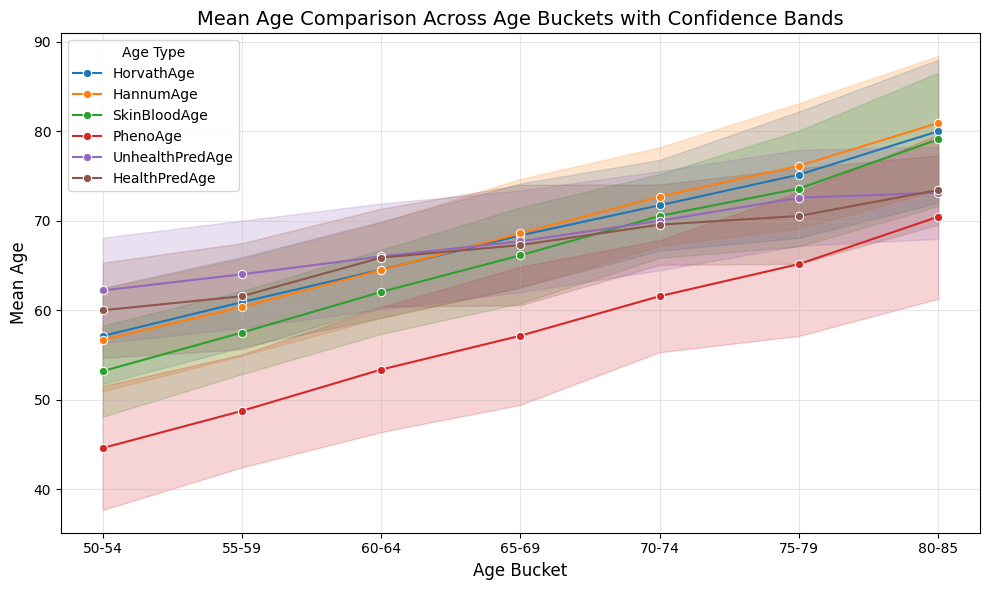

In [52]:
long_data = dna.melt(id_vars=['age_bucket'], 
                     value_vars=['HorvathAge', 'HannumAge', 'SkinBloodAge', 'PhenoAge'], 
                     var_name='Age Type', 
                     value_name='Age')

stacked_long_data = pd.concat([long_data, unhealthy_long, healthy_long], axis=0)

stacked_long_data.reset_index(drop=True, inplace=True)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=stacked_long_data, x='age_bucket', y='Age', hue='Age Type', ci='sd', marker='o')

# Customize the plot
plt.xlabel('Age Bucket', fontsize=12)
plt.ylabel('Mean Age', fontsize=12)
plt.title('Mean Age Comparison Across Age Buckets with Confidence Bands', fontsize=14)
plt.legend(title='Age Type')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

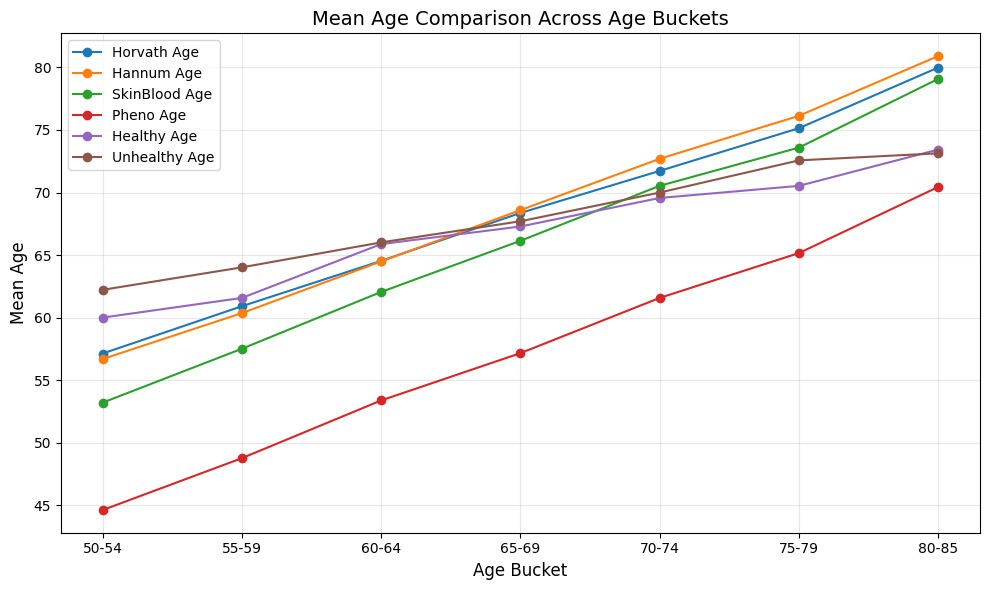

In [53]:
# Plot Mean Age
plt.figure(figsize=(10, 6))
plt.plot(merged_buckets['age_bucket'], merged_buckets['mean_horvath_age'], label='Horvath Age', marker='o')
plt.plot(merged_buckets['age_bucket'], merged_buckets['mean_hannum_age'], label='Hannum Age', marker='o')
plt.plot(merged_buckets['age_bucket'], merged_buckets['mean_skinblood_age'], label='SkinBlood Age', marker='o')
plt.plot(merged_buckets['age_bucket'], merged_buckets['mean_pheno_age'], label='Pheno Age', marker='o')
plt.plot(merged_buckets['age_bucket'], merged_buckets['mean_healthy_pred_age'], label='Healthy Age', marker='o')
plt.plot(merged_buckets['age_bucket'], merged_buckets['mean_unhealthy_pred_age'], label='Unhealthy Age', marker='o')
plt.xlabel('Age Bucket', fontsize=12)
plt.ylabel('Mean Age', fontsize=12)
plt.title('Mean Age Comparison Across Age Buckets', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [55]:
merged_residuals

,age_bucket,mean_horvath_age_res,std_horvath_age_res,mean_hannum_age_res,std_hannum_age_res,mean_skinblood_age_res,std_skinblood_age_res,mean_pheno_age_res,std_pheno_age_res,mean_healthy_residual,std_healthy_residual,mean_unhealthy_residual,std_unhealthy_residual
0,50-54,4.311784,5.252478,3.872645,5.598678,0.388164,4.940663,-8.196634,6.815702,7.007283,5.917820,9.285341,5.973271
1,55-59,2.691357,4.799505,2.140704,5.142677,-0.706990,4.331822,-9.451741,6.077610,3.682821,6.023425,5.726603,5.944167
2,60-64,1.651043,5.213689,1.607759,5.201973,-0.831723,4.519858,-9.500717,6.813357,2.632184,5.785867,3.064001,5.895880
3,65-69,0.385125,5.692547,0.610837,6.015931,-1.840826,5.263357,-10.818541,7.628276,-0.962948,5.908661,-0.272148,5.774347
4,70-74,-1.104799,5.086534,-0.135369,5.399508,-2.297410,4.629695,-11.253857,6.204289,-3.388213,4.535654,-2.896769,5.759339
5,75-79,-2.788455,6.981570,-1.797410,6.926456,-4.339248,6.414678,-12.767602,8.001351,-7.994623,5.484282,-5.370365,5.547530
6,80-85,-3.473510,7.736200,-2.556170,7.300892,-4.382322,7.197071,-13.017460,8.856521,-9.025738,3.997311,-9.164346,5.273007


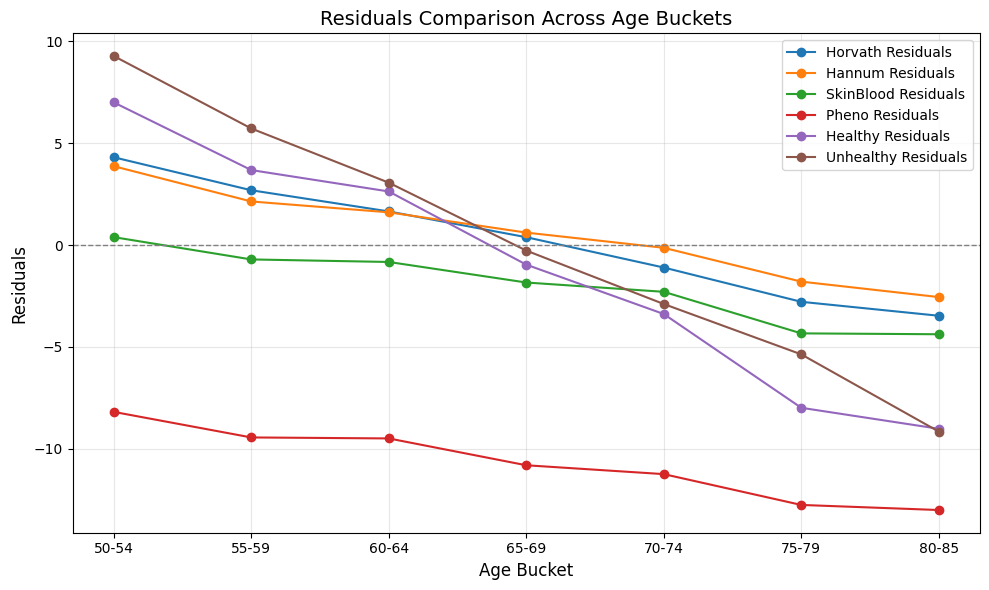

In [56]:
# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(merged_residuals['age_bucket'], merged_residuals['mean_horvath_age_res'], label='Horvath Residuals', marker='o')
plt.plot(merged_residuals['age_bucket'], merged_residuals['mean_hannum_age_res'], label='Hannum Residuals', marker='o')
plt.plot(merged_residuals['age_bucket'], merged_residuals['mean_skinblood_age_res'], label='SkinBlood Residuals', marker='o')
plt.plot(merged_residuals['age_bucket'], merged_residuals['mean_pheno_age_res'], label='Pheno Residuals', marker='o')
plt.plot(merged_residuals['age_bucket'], merged_residuals['mean_healthy_residual'], label='Healthy Residuals', marker='o')
plt.plot(merged_residuals['age_bucket'], merged_residuals['mean_unhealthy_residual'], label='Unhealthy Residuals', marker='o')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Age Bucket', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residuals Comparison Across Age Buckets', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# add confidence band (lighter color or bar)
# refit model on age 50+
# Concordance index to quantify model performance

In [85]:
unhealthy_pred

,actual,UnhealthPredAge,SEQN,n_risks,smoker,residual
0,55.0,58.758585,21009.0,1,False,3.758585
1,52.0,62.730267,21010.0,1,False,10.730267
2,83.0,81.733646,21015.0,1,False,-1.266354
3,50.0,60.767435,21019.0,1,False,10.767435
4,57.0,58.907066,21033.0,1,False,1.907066
...,...,...,...,...,...,...
2499,60.0,64.998040,41452.0,1,False,4.998040
2500,66.0,75.152352,41454.0,1,True,9.152352
2501,71.0,65.103541,41460.0,1,False,-5.896459
2502,58.0,61.534617,41466.0,1,False,3.534617


In [ ]:
dna_predictors = ['HorvathAge', 'HannumAge', 'SkinBloodAge', 'PhenoAge']
healthy_predictors = ['HealthPredAge']
unhealthy_predictors = ['UnhealthPredAge']

results = []

for predictor in dna_predictors:
    complete_data = dna.dropna(subset=[predictor, 'true_age'])
    c_index = concordance_index(event_times=complete_data.true_age, predicted_scores=complete_data[predictor])
    results.append({'Dataset': 'dna', 'Predictor': predictor, 'Concordance Index': c_index})

for predictor in healthy_predictors:
    complete_data = healthy_pred.dropna(subset=[predictor, 'Actual Age'])
    c_index = concordance_index(event_times=complete_data['Actual Age'], predicted_scores=complete_data[predictor])
    results.append({'Dataset': 'healthy_pred', 'Predictor': predictor, 'Concordance Index': c_index})

for predictor in unhealthy_predictors:
    complete_data = unhealthy_pred.dropna(subset=[predictor, 'actual'])
    c_index = concordance_index(event_times=complete_data.actual, predicted_scores=complete_data[predictor])
    results.append({'Dataset': 'unhealthy_pred', 'Predictor': predictor, 'Concordance Index': c_index})

results_df = pd.DataFrame(results)

results_df.set_index(['Dataset', 'Predictor'], inplace=True)

print(results_df)

                                Concordance Index
Dataset        Predictor                         
dna            HorvathAge                0.829823
               HannumAge                 0.836169
               SkinBloodAge              0.871683
               PhenoAge                  0.806313
healthy_pred   HealthPredAge             0.725631
unhealthy_pred UnhealthPredAge           0.694619


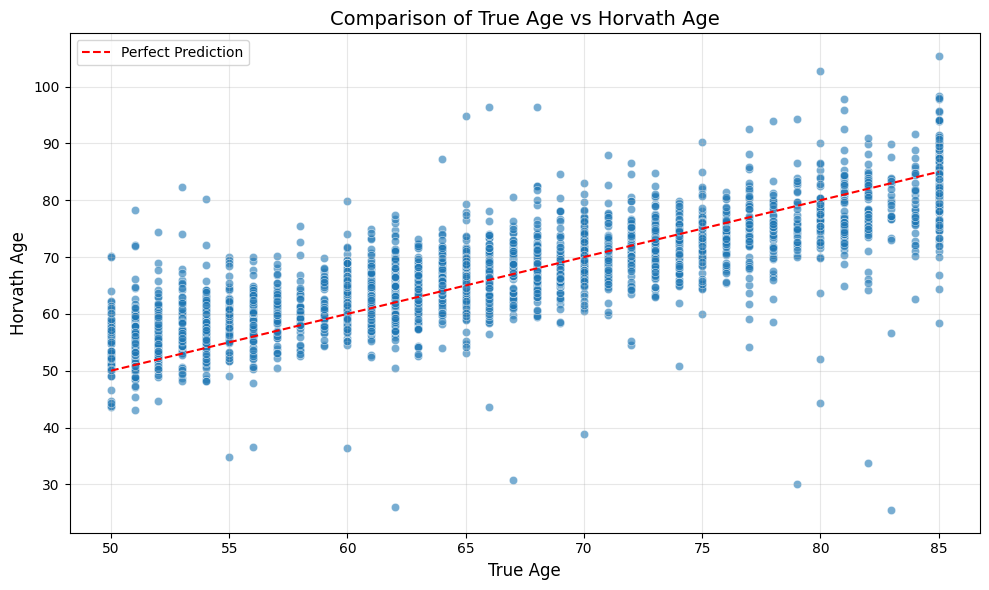

In [64]:
plot_data = dna.dropna(subset=['true_age', 'HorvathAge'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='true_age', y='HorvathAge', alpha=0.6)

plt.plot([plot_data['true_age'].min(), plot_data['true_age'].max()],
         [plot_data['true_age'].min(), plot_data['true_age'].max()],
         'r--', label='Perfect Prediction')

plt.xlabel('True Age', fontsize=12)
plt.ylabel('Horvath Age', fontsize=12)
plt.title('Comparison of True Age vs Horvath Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

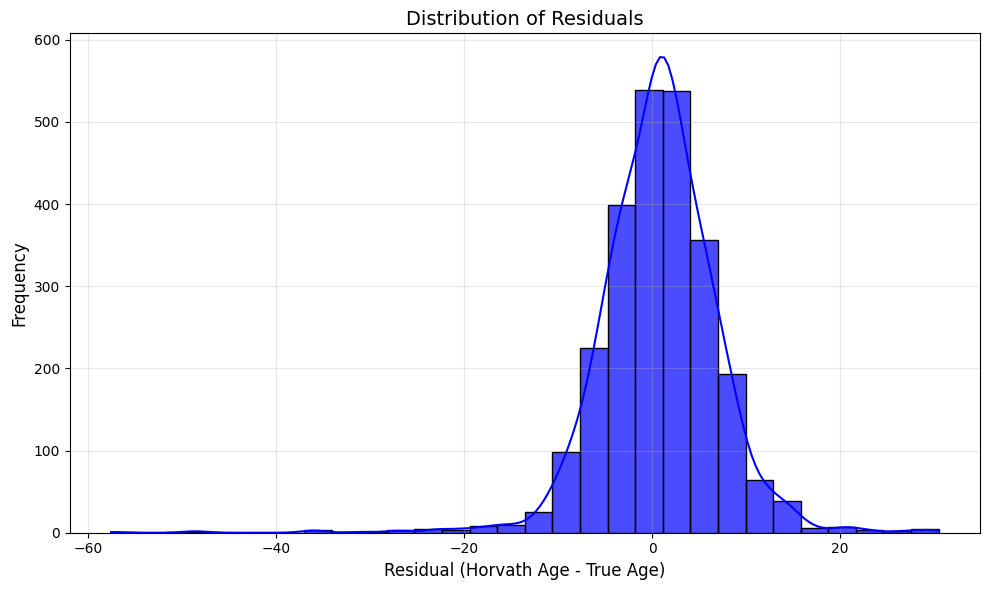

In [147]:
plt.figure(figsize=(10, 6))
sns.histplot(dna['horvath_residual'], kde=True, bins=30, color='blue', alpha=0.7)

plt.xlabel('Residual (Horvath Age - True Age)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

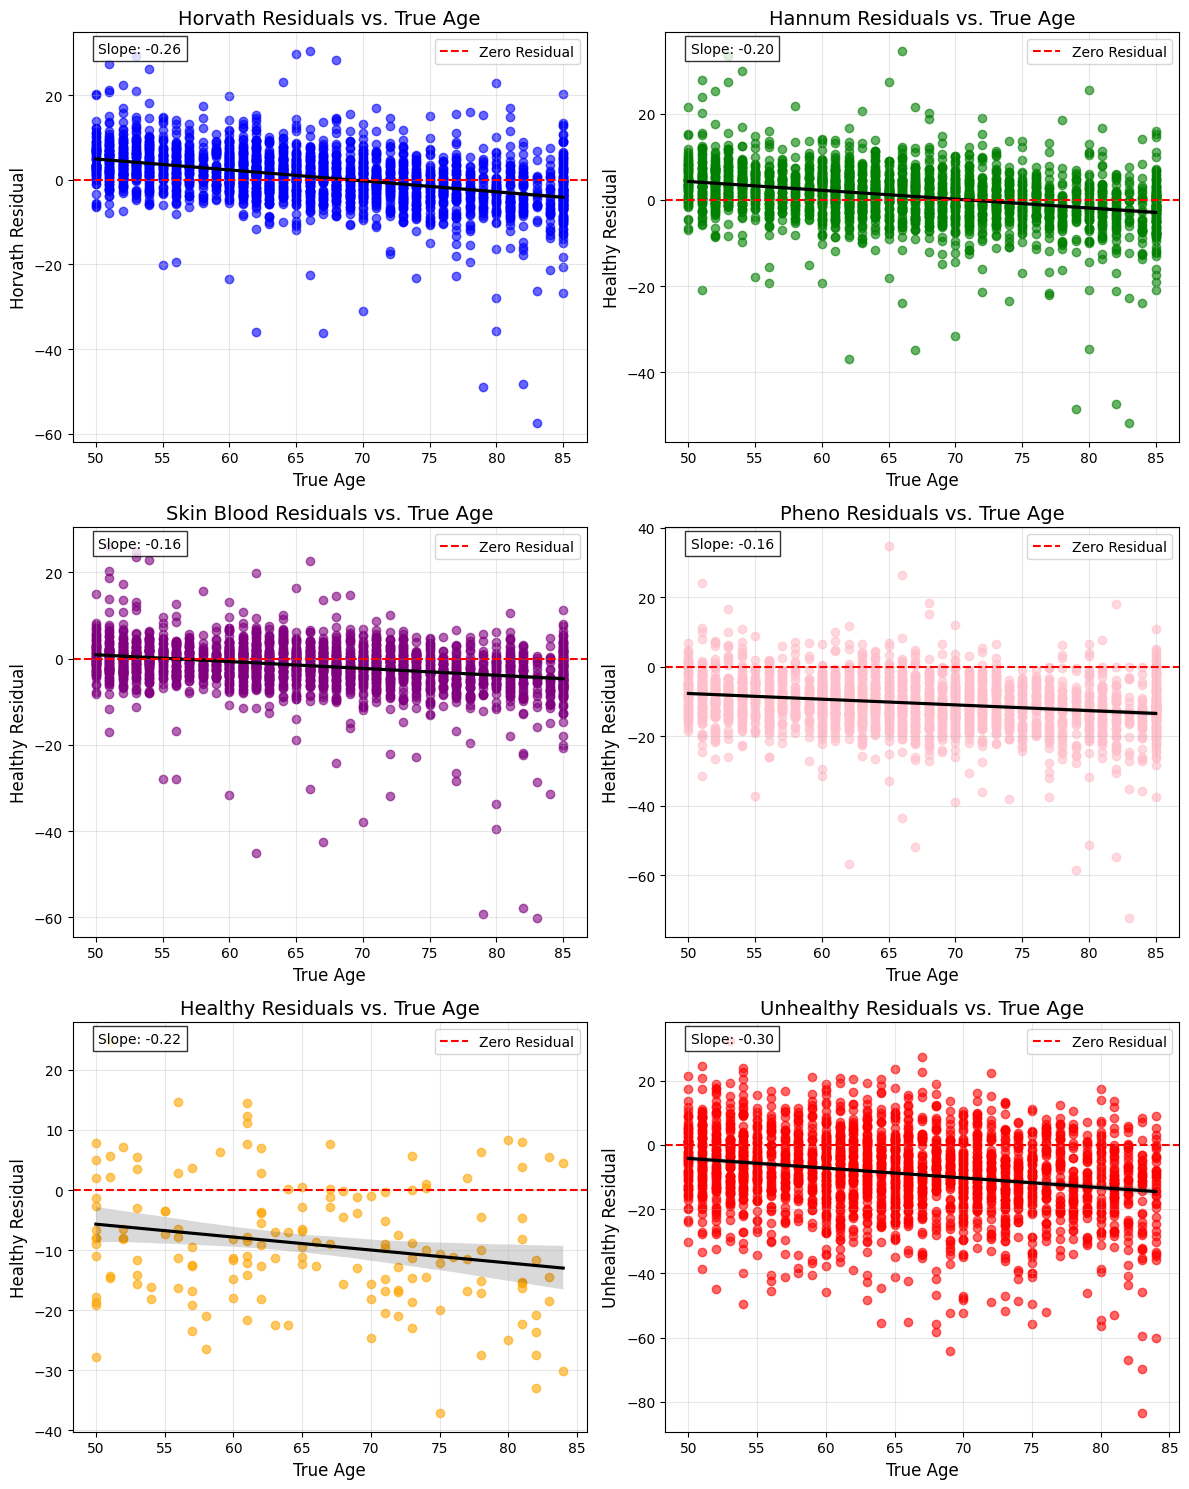

In [166]:
dna = dna.dropna(subset=['true_age', 'horvath_residual', 'hannum_residual'])

plt.figure(figsize=(12, 15))

plt.subplot(3, 2, 1)
sns.regplot(data=dna, x='true_age', y='horvath_residual', color='blue', scatter_kws={'alpha': 0.6}, line_kws={'color': 'black'})
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
slope, intercept = np.polyfit(dna['true_age'], dna['horvath_residual'], 1)
plt.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Horvath Residual', fontsize=12)
plt.title('Horvath Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 2, 2)
sns.regplot(data=dna, x='true_age', y='hannum_residual', color='green', scatter_kws={'alpha': 0.6}, line_kws={'color': 'black'})
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
slope, intercept = np.polyfit(dna['true_age'], dna['hannum_residual'], 1)
plt.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Healthy Residual', fontsize=12)
plt.title('Hannum Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 2, 3)
sns.regplot(data=dna, x='true_age', y='skinblood_residual', color='purple', scatter_kws={'alpha': 0.6}, line_kws={'color': 'black'})
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
slope, intercept = np.polyfit(dna['true_age'], dna['skinblood_residual'], 1)
plt.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Healthy Residual', fontsize=12)
plt.title('Skin Blood Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 2, 4)
sns.regplot(data=dna, x='true_age', y='pheno_residual', color='pink', scatter_kws={'alpha': 0.6}, line_kws={'color': 'black'})
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
slope, intercept = np.polyfit(dna['true_age'], dna['pheno_residual'], 1)
plt.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Healthy Residual', fontsize=12)
plt.title('Pheno Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 2, 5)
sns.regplot(data=healthy_pred, x='Actual Age', y='residual', color='orange', scatter_kws={'alpha': 0.6}, line_kws={'color': 'black'})
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
slope, intercept = np.polyfit(healthy_pred['Actual Age'], healthy_pred['residual'], 1)
plt.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Healthy Residual', fontsize=12)
plt.title('Healthy Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(3, 2, 6)
sns.regplot(data=unhealthy_pred, x='actual', y='residual', color='red', scatter_kws={'alpha': 0.6}, line_kws={'color': 'black'})
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
slope, intercept = np.polyfit(unhealthy_pred['actual'], unhealthy_pred['residual'], 1)
plt.text(0.05, 0.95, f"Slope: {slope:.2f}", transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Unhealthy Residual', fontsize=12)
plt.title('Unhealthy Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

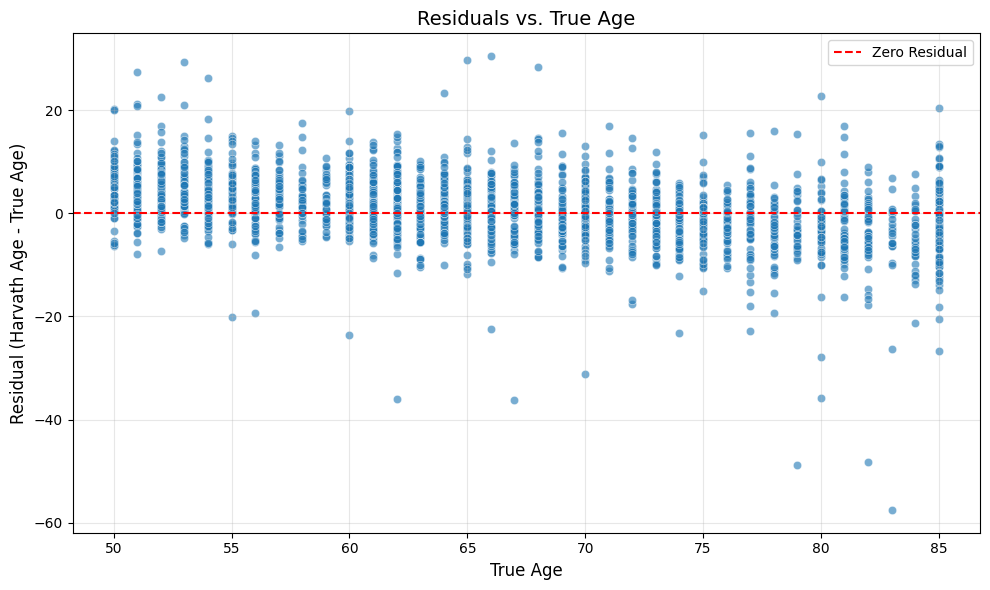

In [148]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dna, x='true_age', y='horvath_residual', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Residual (Harvath Age - True Age)', fontsize=12)
plt.title('Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

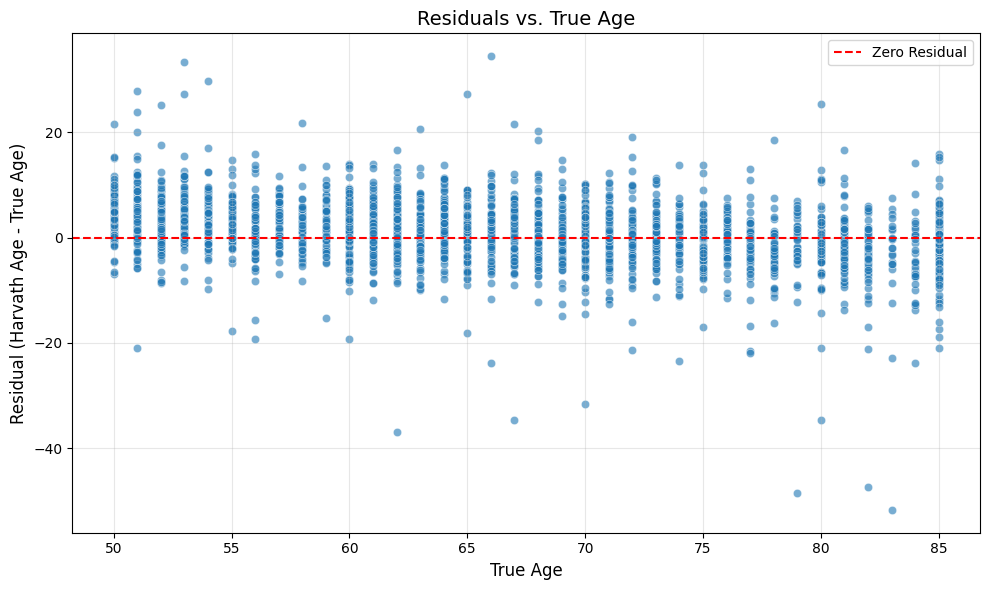

In [149]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dna, x='true_age', y='hannum_residual', alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('True Age', fontsize=12)
plt.ylabel('Residual (Harvath Age - True Age)', fontsize=12)
plt.title('Residuals vs. True Age', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/2850924836.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dna, x='age_bucket', y='horvath_residual', palette='coolwarm')


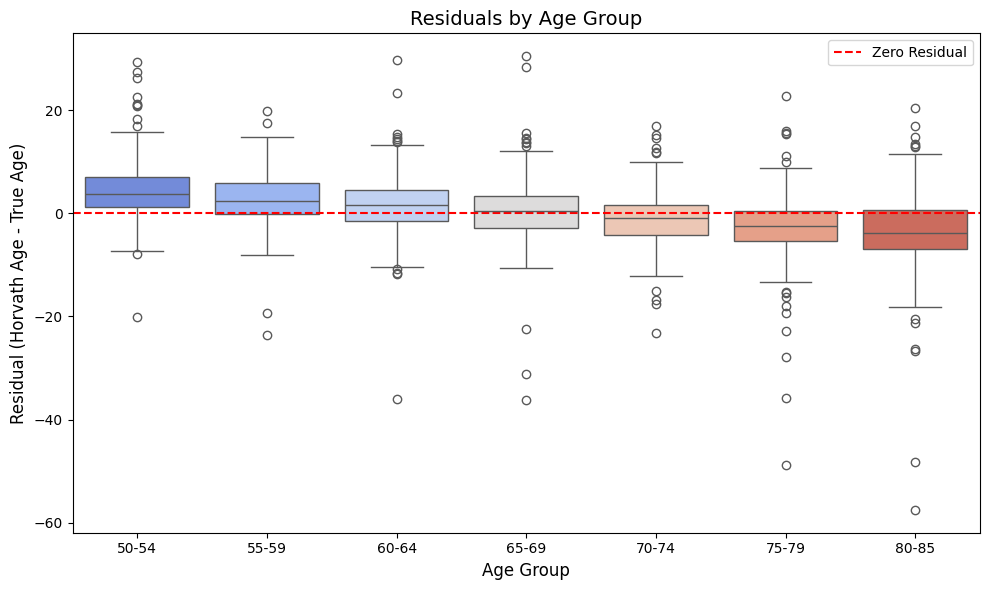

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dna, x='age_bucket', y='horvath_residual', palette='coolwarm')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Residual (Horvath Age - True Age)', fontsize=12)
plt.title('Residuals by Age Group', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/2133110355.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=unhealthy_pred, x='age_bucket', y='residual', palette='coolwarm')


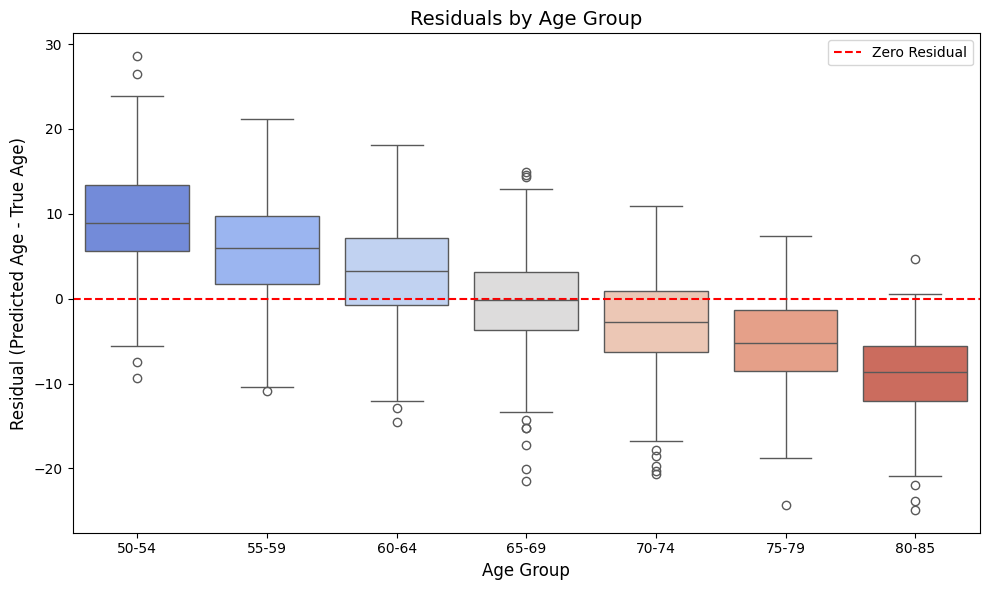

In [62]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=unhealthy_pred, x='age_bucket', y='residual', palette='coolwarm')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Residual (Predicted Age - True Age)', fontsize=12)
plt.title('Residuals by Age Group', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/2028796594.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dna, x='age_bucket', y='horvath_residual', palette='coolwarm')
/var/folders/dz/ggx10pdx1p91s2hsnvsw_sy40000gn/T/ipykernel_25701/2028796594.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=unhealthy_pred, x='age_bucket', y='residual', palette='coolwarm')


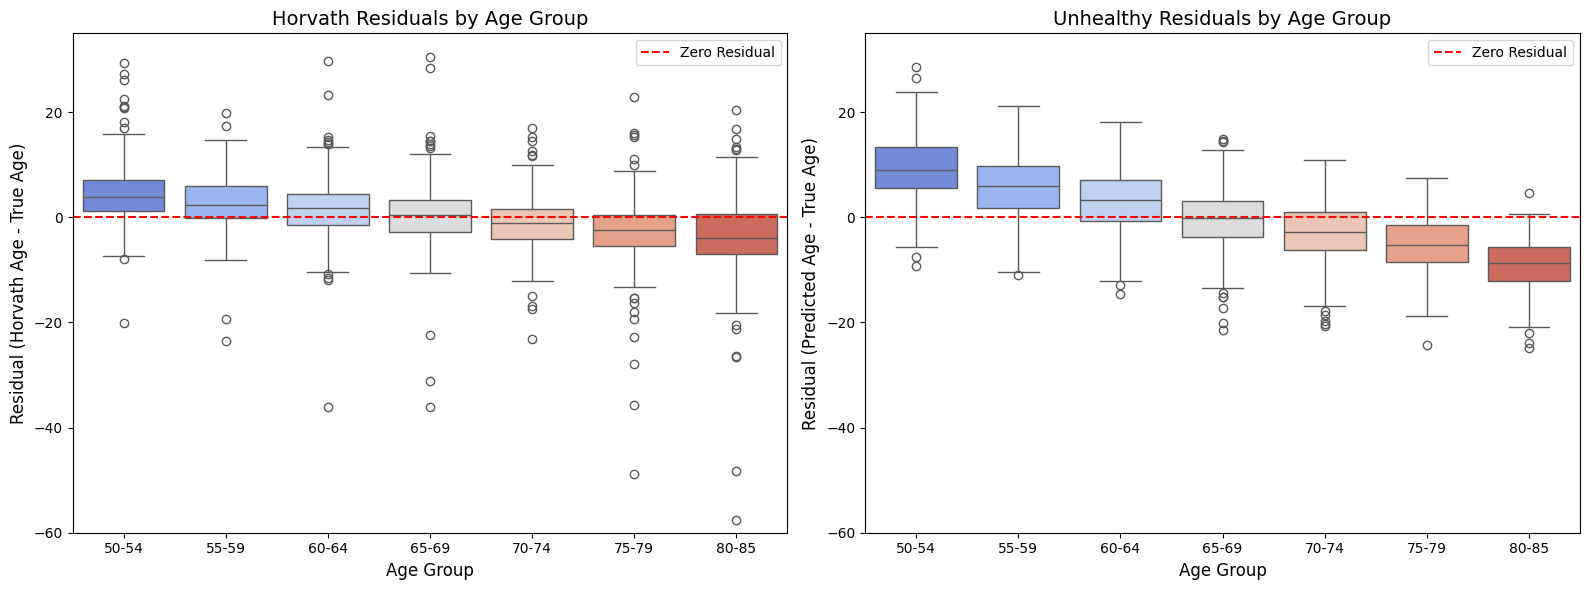

In [69]:
plt.figure(figsize=(16, 6))

# Plot 1: Horvath Residuals
plt.subplot(1, 2, 1)
sns.boxplot(data=dna, x='age_bucket', y='horvath_residual', palette='coolwarm')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Residual (Horvath Age - True Age)', fontsize=12)
plt.title('Horvath Residuals by Age Group', fontsize=14)
plt.ylim(-60, 35)
plt.legend()

# Plot 2: Unhealthy Residuals
plt.subplot(1, 2, 2)
sns.boxplot(data=unhealthy_pred, x='age_bucket', y='residual', palette='coolwarm')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Residual (Predicted Age - True Age)', fontsize=12)
plt.title('Unhealthy Residuals by Age Group', fontsize=14)
plt.ylim(-60, 35)
plt.legend()

plt.tight_layout()
plt.show()